In [1]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

In [2]:
class CnnNet(nn.Module):  
    def __init__(self):
        super(CnnNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 6 * 6, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 64 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [3]:
class CnnNet2(nn.Module):  
    def __init__(self):
        super(CnnNet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7200, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10) 
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [4]:
class CnnNet3(nn.Module):  
    def __init__(self):
        super(CnnNet3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10) 
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [5]:
print("model 1 - parameters", sum(p.numel() for p in CnnNet().parameters() if p.requires_grad))
print("model 2 - parameters", sum(p.numel() for p in CnnNet2().parameters() if p.requires_grad))
print("model 3 - parameters", sum(p.numel() for p in CnnNet3().parameters() if p.requires_grad))

model 1 - parameters 2389962
model 2 - parameters 7639690
model 3 - parameters 883530


In [6]:
def train( model, device, train_loader, optimizer,loss_fn, epoch):
    train_loss=0
    model.train()
    correct = 0
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss/=len(train_loader.dataset)
    print("Training - Epoch:", epoch, "loss:", train_loss, "accuracy:", 100. * correct / len(train_loader.dataset))  
    return train_loss, 100. * correct / len(train_loader.dataset)
                                                       
                                                       
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)

In [8]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 512}
test_kwargs = {'batch_size': 512}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
dataset2 = datasets.CIFAR10('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)


Files already downloaded and verified


In [11]:
model = CnnNet().to(device)
summary(model,(3 ,32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 13, 13]          18,496
         MaxPool2d-4             [-1, 64, 6, 6]               0
           Dropout-5             [-1, 64, 6, 6]               0
            Linear-6                 [-1, 1024]       2,360,320
            Linear-7                   [-1, 10]          10,250
Total params: 2,389,962
Trainable params: 2,389,962
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.40
Params size (MB): 9.12
Estimated Total Size (MB): 9.53
----------------------------------------------------------------


In [12]:
model = CnnNet2().to(device)
summary(model,(3 ,32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
           Dropout-3           [-1, 32, 15, 15]               0
            Linear-4                 [-1, 1024]       7,373,824
            Linear-5                  [-1, 256]         262,400
           Dropout-6                  [-1, 256]               0
            Linear-7                   [-1, 10]           2,570
Total params: 7,639,690
Trainable params: 7,639,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.34
Params size (MB): 29.14
Estimated Total Size (MB): 29.50
----------------------------------------------------------------


In [13]:
model = CnnNet3().to(device)
summary(model,(3 ,32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 13, 13]          18,496
         MaxPool2d-4             [-1, 64, 6, 6]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
         MaxPool2d-6            [-1, 128, 2, 2]               0
           Dropout-7            [-1, 128, 2, 2]               0
            Linear-8                 [-1, 1024]         525,312
            Linear-9                  [-1, 256]         262,400
          Dropout-10                  [-1, 256]               0
           Linear-11                   [-1, 10]           2,570
Total params: 883,530
Trainable params: 883,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [15]:
def returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch, scheduler):
    train_loss=[]
    test_loss=[]
    accuracy_train=[]
    accuracy_test=[]
    for epoch in range(1, epoch+1):
        tr_loss, tr_accuracy=train(model, device, train_loader, optimizer, loss, epoch)
        train_loss.append(tr_loss)
        accuracy_train.append(tr_accuracy)
    return train_loss, accuracy_train, test_loss, accuracy_test

In [16]:
epoch=50
model = CnnNet().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss = nn.CrossEntropyLoss(reduction='sum')
train_loss_1, accuracy_train_1, _, _ = returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch, scheduler)

Training - Epoch: 1 loss: 2.1939428918457033 accuracy: 20.824
Training - Epoch: 2 loss: 1.9191671789550782 accuracy: 31.324
Training - Epoch: 3 loss: 1.786243515625 accuracy: 36.428
Training - Epoch: 4 loss: 1.6875599353027344 accuracy: 39.918
Training - Epoch: 5 loss: 1.6284932946777344 accuracy: 41.83
Training - Epoch: 6 loss: 1.5910656274414063 accuracy: 42.966
Training - Epoch: 7 loss: 1.5626575073242188 accuracy: 44.112
Training - Epoch: 8 loss: 1.5383092602539064 accuracy: 45.048
Training - Epoch: 9 loss: 1.5187888317871094 accuracy: 45.818
Training - Epoch: 10 loss: 1.501534400024414 accuracy: 46.468
Training - Epoch: 11 loss: 1.4857425701904297 accuracy: 47.136
Training - Epoch: 12 loss: 1.4686013232421875 accuracy: 47.994
Training - Epoch: 13 loss: 1.4564699011230469 accuracy: 48.324
Training - Epoch: 14 loss: 1.4423794635009766 accuracy: 48.988
Training - Epoch: 15 loss: 1.4286403009033204 accuracy: 49.418
Training - Epoch: 16 loss: 1.4195747259521485 accuracy: 49.79
Training

In [17]:
epoch=50
model = CnnNet2().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss = nn.CrossEntropyLoss()
train_loss_2, accuracy_train_2, _, _ = returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch, scheduler)

Training - Epoch: 1 loss: 2.1390230200195313 accuracy: 22.488
Training - Epoch: 2 loss: 1.9046167883300782 accuracy: 31.646
Training - Epoch: 3 loss: 1.7843521020507813 accuracy: 36.19
Training - Epoch: 4 loss: 1.694519569091797 accuracy: 39.768
Training - Epoch: 5 loss: 1.6345075061035157 accuracy: 41.438
Training - Epoch: 6 loss: 1.5892871044921875 accuracy: 42.934
Training - Epoch: 7 loss: 1.5600376879882814 accuracy: 43.924
Training - Epoch: 8 loss: 1.5287104125976563 accuracy: 45.13
Training - Epoch: 9 loss: 1.5045524896240234 accuracy: 45.82
Training - Epoch: 10 loss: 1.4848819897460936 accuracy: 46.638
Training - Epoch: 11 loss: 1.4663147192382813 accuracy: 47.57
Training - Epoch: 12 loss: 1.452234168701172 accuracy: 47.728
Training - Epoch: 13 loss: 1.4323680114746093 accuracy: 48.544
Training - Epoch: 14 loss: 1.4189097412109375 accuracy: 49.106
Training - Epoch: 15 loss: 1.4069111907958984 accuracy: 49.68
Training - Epoch: 16 loss: 1.3904746905517578 accuracy: 50.194
Training

In [18]:
epoch=50
model = CnnNet3().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss = nn.CrossEntropyLoss()
train_loss_3, accuracy_train_3, _, _ = returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch, scheduler)

Training - Epoch: 1 loss: 2.2881465185546874 accuracy: 12.468
Training - Epoch: 2 loss: 2.1668486596679686 accuracy: 18.284
Training - Epoch: 3 loss: 2.061863966064453 accuracy: 22.462
Training - Epoch: 4 loss: 1.9816204638671875 accuracy: 25.274
Training - Epoch: 5 loss: 1.91118923828125 accuracy: 27.798
Training - Epoch: 6 loss: 1.845581329345703 accuracy: 30.25
Training - Epoch: 7 loss: 1.8036764013671875 accuracy: 31.784
Training - Epoch: 8 loss: 1.7748234326171874 accuracy: 33.024
Training - Epoch: 9 loss: 1.7540265856933595 accuracy: 33.874
Training - Epoch: 10 loss: 1.7334665270996095 accuracy: 34.968
Training - Epoch: 11 loss: 1.7175290380859376 accuracy: 35.606
Training - Epoch: 12 loss: 1.7016568237304688 accuracy: 36.266
Training - Epoch: 13 loss: 1.6870423510742187 accuracy: 37.092
Training - Epoch: 14 loss: 1.6750964855957031 accuracy: 37.492
Training - Epoch: 15 loss: 1.6598251599121094 accuracy: 38.366
Training - Epoch: 16 loss: 1.6462690563964844 accuracy: 38.824
Traini

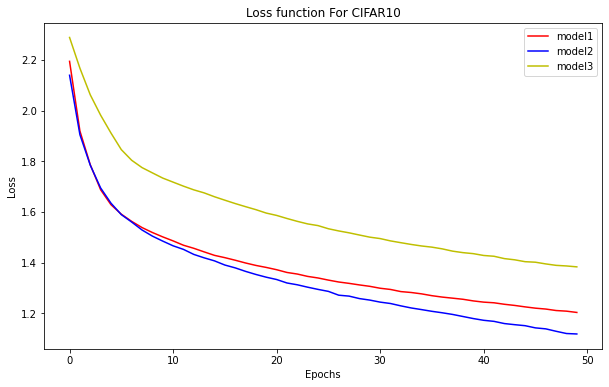

In [19]:
import matplotlib.pyplot as plt
plt1=plt.figure(figsize=(10, 6))
plt.plot(np.array(train_loss_1), 'r', label='model1')
plt.plot(np.array(train_loss_2), 'b', label='model2')
plt.plot(np.array(train_loss_3), 'y', label='model3')

# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Loss') 
plt.legend()
plt.title("Loss function For CIFAR10")
plt.show()




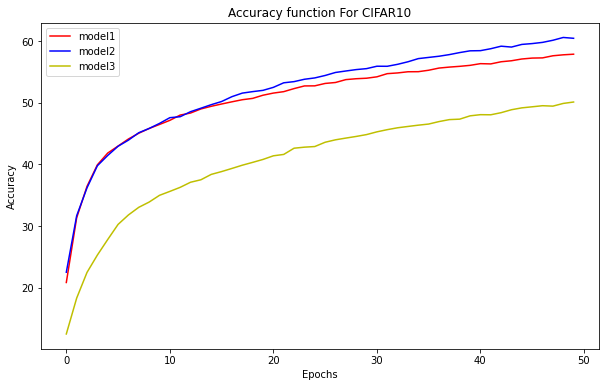

In [20]:
plt1=plt.figure(figsize=(10, 6))
plt.plot(np.array(accuracy_train_1), 'r', label='model1')
plt.plot(np.array(accuracy_train_2), 'b', label='model2')
plt.plot(np.array(accuracy_train_3), 'y', label='model3')

# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Accuracy') 
plt.legend()
plt.title("Accuracy function For CIFAR10")
plt.show()